#  Quick look at NIRPS proxima data

In [1]:
from typing import List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import sigma_clip
from astropy.table import Table
from astropy.timeseries import LombScargle
from matplotlib.axes import Axes
from matplotlib.figure import Figure
import nirps_tools as nirps
import yaml

### Read input file

In [2]:
star = input('Enter star name:')

print('Loading input file and data...')
### System info
working_path = f"stars/{star}/"

# Read input file
try: 
    with open(working_path + 'input.yaml', 'r') as file:
        data = yaml.safe_load(file)
except FileNotFoundError:
    print('This star does not exist in the database.')
    raise

system_info = data['star']  # Initialize as a list of one empty dictionary if no star data found
instruments = data['instruments']
ccf = data['CCF']

print('Done.')

Loading input file and data...
Done.


System info

## Loading the data

In [3]:
tbl = {}
tbl_ccf = {}
rv_off = {}
rv_off_ccf = {}
tlabel = "t"

# Name of files
files = {}

# Adjust the file labels
Dtemp_suf = []

# # Get the CCF data if it exists
for instrument in ccf:
    tbl_ccf[instrument] = {}
    if ccf[instrument]['DRS-3-0-0']: 
        tbl_ccf[instrument]['DRS-3-0-0'] = Table.read(f'stars/{star}/data/{star}_{instrument}_DRS-3-0-0.rdb', format='rdb')
        tbl_ccf[instrument]['DRS-3-0-0'][tlabel] = tbl_ccf[instrument]['DRS-3-0-0']["rjd"] #- extra_off

    if ccf[instrument]['DRS-3-5']:
        tbl_ccf[instrument]['DRS-3-5'] = Table.read(f'stars/{star}/data/{star}_{instrument}_DRS-3-5.rdb', format='rdb')
        tbl_ccf[instrument]['DRS-3-5'][tlabel] = tbl_ccf[instrument]['DRS-3-5']["rjd"] #- extra_off
    

i = 0
for instrument in instruments:
    star_name = system_info.get('name', '')  # Accessing the first element of the star_info list
    ref_star = instruments[instrument].get('ref_star', '')
    suffix = instruments[instrument].get('dtemp_suffix', '')
    bin_label = instruments[instrument].get('bin_label', '')
    pca_label = instruments[instrument].get('pca_label', '')
    Dtemp_suf.append(instruments[instrument].get('dtemp_suffix', ''))
    
    files[instrument] = f'stars/{star}/data/lbl{bin_label}_{instrument}_{star}_{ref_star}{pca_label}'
    
    tbl[instrument] = Table.read(files[instrument]+'.rdb', format='rdb')
    
    # Remove NaNs 
    tbl[instrument] = nirps.remove_nans_from_table(tbl[instrument])
        
    rv_off[instrument] = np.median(tbl[instrument]["vrad"])
    tbl[instrument]["vrad"] -= rv_off[instrument]
    
    if ccf[instrument]['DRS-3-0-0']:
        rv_off_ccf[instrument] = np.median(tbl_ccf[instrument]['DRS-3-0-0']["vrad"])
        tbl_ccf[instrument]['DRS-3-0-0']["vrad"] -= rv_off_ccf[instrument]

    #rjd_bjd_off = 2457000
    #extra_off_factor = 100
    #extra_off = np.floor(tbl[instrument]["rjd"].min() / extra_off_factor) * extra_off_factor
    #t_off = rjd_bjd_off + extra_off


    tbl[instrument][tlabel] = tbl[instrument]["rjd"] #- extra_off
    i+=1

## Timeseries and periodograms

In [4]:
qty_list = {}
qty_labels = {}
qty_units = {}
qty_ccf_list = {}
qty_ccf_labels = {}
qty_ccf_units = {}

i = 0
for instrument in instruments:
    # LBL labels
    qty_list[instrument] = ["vrad", "d2v", "d3v","DTEMP"+Dtemp_suf[i]]
    qty_labels[instrument] = {
        "vrad": "RV",
        "d2v": "D2V",
        "d3v": "D3V",
        "DTEMP"+Dtemp_suf[i]: "$\Delta$T",
    }
    qty_units[instrument] = {
        "vrad": "m/s",
        "d2v": "m$^2$ / s$^2$",
        "d3v": "m$^3$ / s$^3$",
        "DTEMP"+Dtemp_suf[i]: "K",
    }
    
    # CCF labels
    qty_ccf_list[instrument] = ['vrad', 'fwhm', 'bis_span']
    qty_ccf_labels[instrument] = {
        "vrad": "RV",
        "fwhm": "FWHM",
        "bis_span": "bissector"}
    qty_ccf_units[instrument] = {"vrad": "m/s",
        "fwhm": "",
        "bis_span": "",
    }
    

    i+=1

LBL data

/home/plamontagne/nirps/nirps_tools.py:180: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  axes[i, 0].errorbar(t, y, yerr=yerr, fmt=err_fmt, label=err_label, color=color)
/home/plamontagne/nirps/nirps_tools.py:180: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  axes[i, 0].errorbar(t, y, yerr=yerr, fmt=err_fmt, label=err_label, color=color)


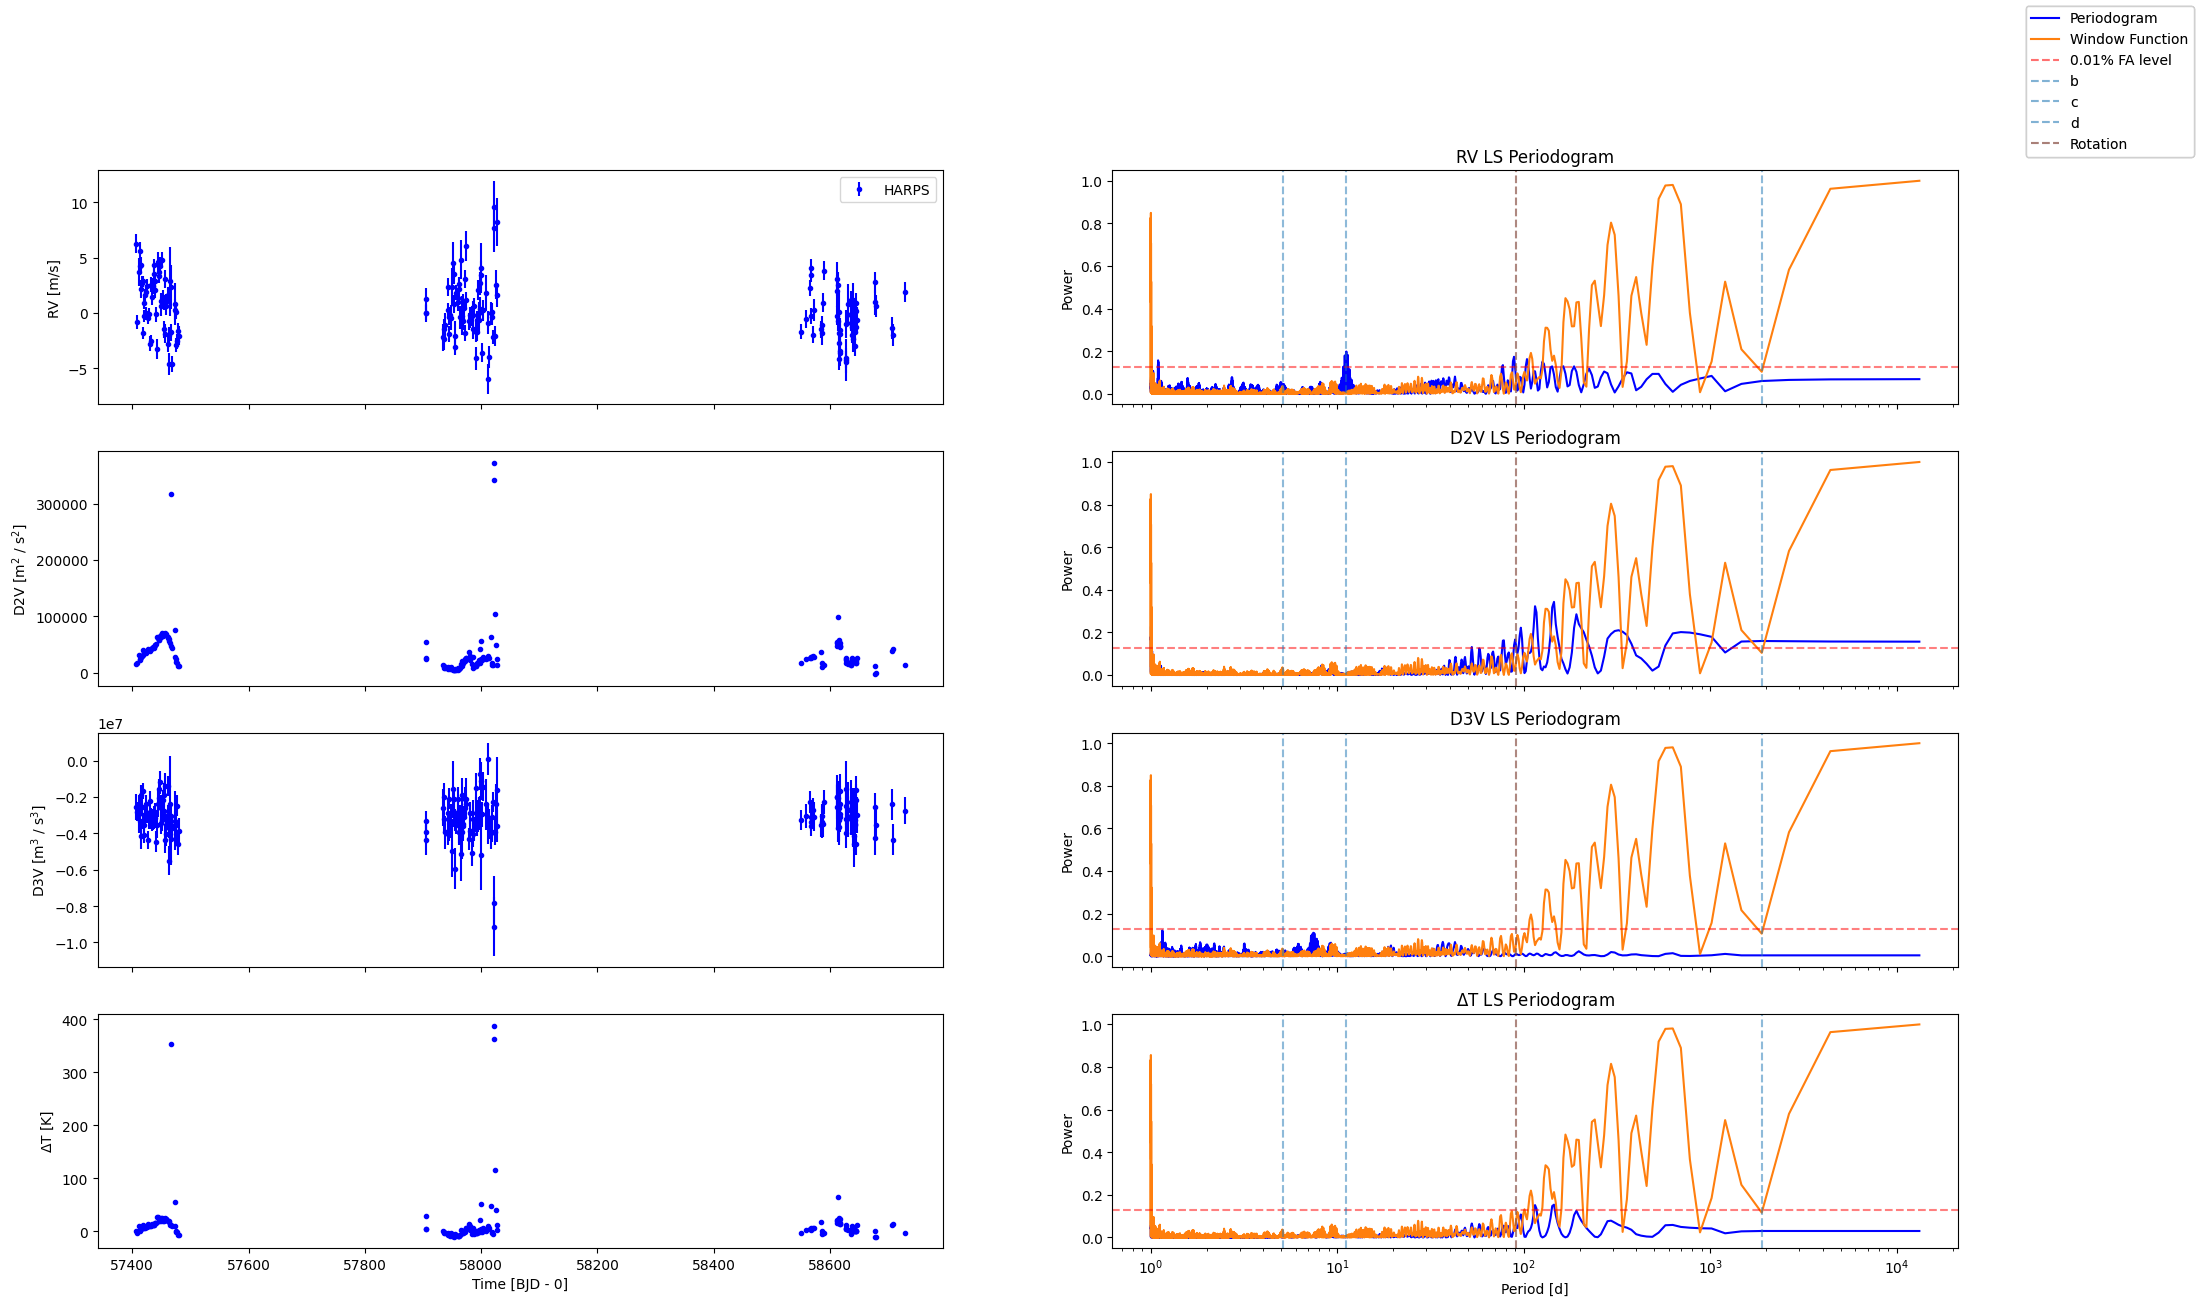

In [5]:
first_time = True
for instrument in instruments: 
    if first_time: 
        fig, axes = nirps.plot_timeseries(tbl[instrument], qty_list[instrument], qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], plot_ls=True, err_label=instrument,
                candidate_planets=system_info['planets'], star_rotation=system_info['period'], color = 'blue')
    else: 
        nirps.plot_timeseries(tbl[instrument], qty_list[instrument], qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], plot_ls=True, err_label=instrument,
                candidate_planets=system_info['planets'], star_rotation=system_info['period'], color = 'red',fig = fig, axes=axes)
        
    
    first_time = False
    
axes[0, 0].legend()
plt.savefig(f"stars/{star}/data/{star}_timeseries.png", dpi=300)
plt.show()

CCF data (v3.0.0)

In [6]:
first_time = True
for instrument in instruments: 
    if first_time: 
        if ccf[instrument]['DRS-3-0-0']: 
            nirps.plot_timeseries(tbl_ccf[instrument]['DRS-3-0-0'], qty_ccf_list[instrument], qty_labels=qty_ccf_labels[instrument], qty_units=qty_ccf_units[instrument], plot_ls=True, err_label=instrument,
                candidate_planets=system_info['planets'], star_rotation=system_info['period'], color = 'green', axes=axes, inc_label='sig_')
            first_time = False
            
    else:  
        if ccf[instrument]['DRS-3-0-0']: 
            nirps.plot_timeseries(tbl_ccf[instrument]['DRS-3-0-0'], qty_list[instrument], qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], plot_ls=True, err_label=instrument,
                candidate_planets=system_info['planets'], star_rotation=system_info['period'], color = 'green',fig = fig, axes=axes, inc_label='sig_')
            
axes[0, 0].legend()
plt.savefig(f"stars/{star}/data/{star}_CCF_timeseries.png", dpi=300)
plt.show()

<Figure size 640x480 with 0 Axes>

## Outlier filtering

In [7]:
mask_sigma = {}
mask_sigma_ccf = {}
for instrument in instruments: 
    mask_sigma[instrument] = nirps.sigma_clip_tbl(tbl[instrument], qty_list[instrument], sigma=3.0)
    
    if ccf[instrument]['DRS-3-0-0']:
        mask_sigma_ccf[instrument] = nirps.sigma_clip_tbl(tbl_ccf[instrument]['DRS-3-0-0'], qty_ccf_list[instrument], sigma=3.0)

/home/plamontagne/nirps/nirps_tools.py:180: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  axes[i, 0].errorbar(t, y, yerr=yerr, fmt=err_fmt, label=err_label, color=color)
/home/plamontagne/nirps/nirps_tools.py:180: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rx" (-> color='r'). The keyword argument will take precedence.
  axes[i, 0].errorbar(t, y, yerr=yerr, fmt=err_fmt, label=err_label, color=color)


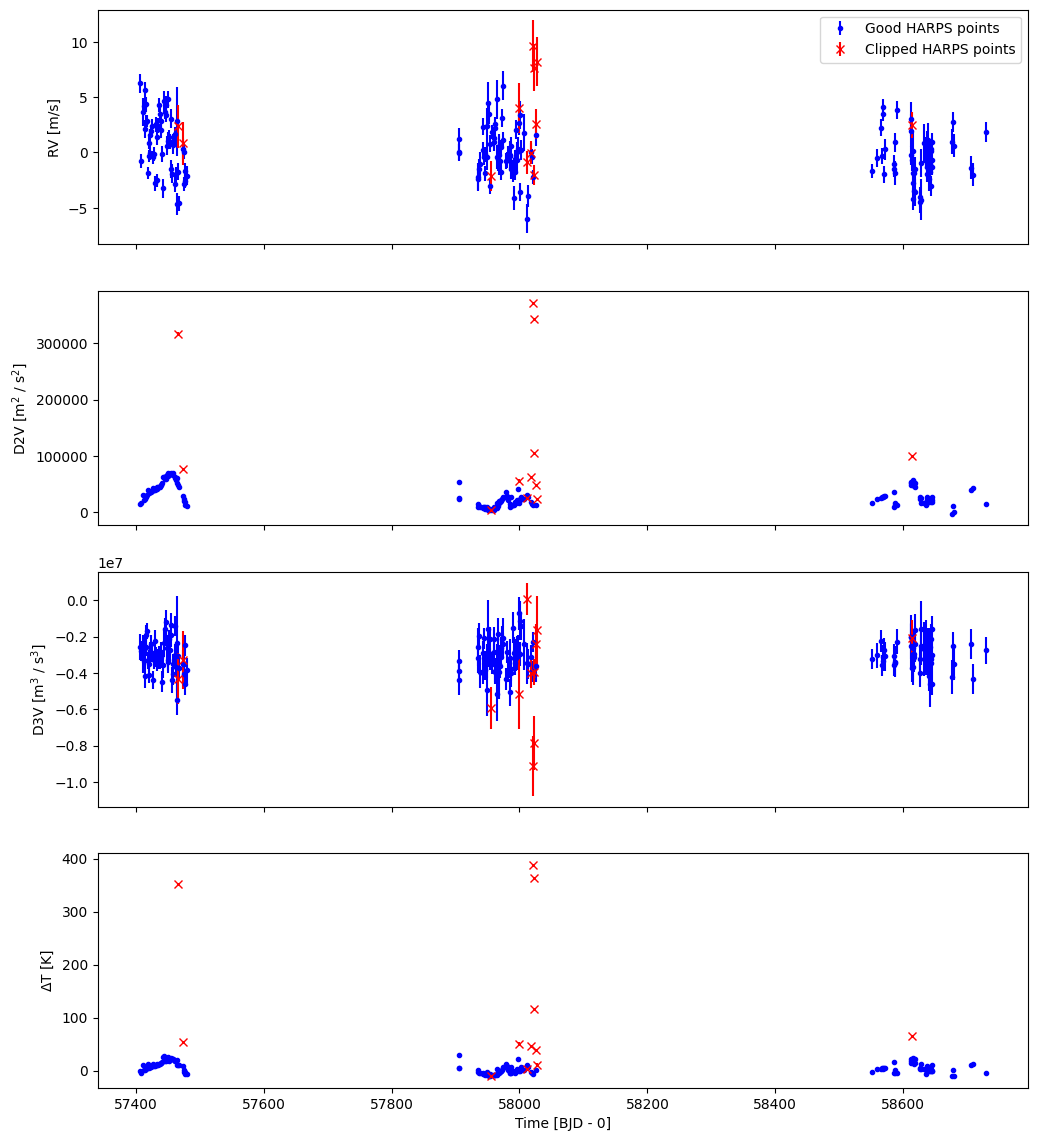

In [8]:
first_time = True
for instrument in instruments: 
    if first_time:
        fig, axes = nirps.plot_timeseries(
            tbl[instrument][~mask_sigma[instrument]], qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], qty_list = qty_list[instrument], plot_ls=False,
            err_label=f"Good {instrument} points", color='blue')
        
        nirps.plot_timeseries(tbl[instrument][mask_sigma[instrument]], 
        qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], qty_list = qty_list[instrument],
        plot_ls=False,
        fig=fig,
        axes=axes,
        err_fmt="rx",
        err_label=f"Clipped {instrument} points",
        color='red')
        
    else:  
        nirps.plot_timeseries(
        tbl[instrument][~mask_sigma[instrument]],
        qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], qty_list = qty_list[instrument],
        plot_ls=False,
        fig=fig,
        axes=axes,
        err_label=f"Good {instrument} points",
        color='purple')
        
        nirps.plot_timeseries(
        tbl[instrument][mask_sigma[instrument]],
        qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], qty_list = qty_list[instrument],
        plot_ls=False,
        fig=fig,
        axes=axes,
        err_fmt="rx",
        err_label=f"Clipped {instrument} points",
        color='orange')
    
    first_time = False
        
axes[0, 0].legend()
plt.show()

## Error-based filtering

HARPS


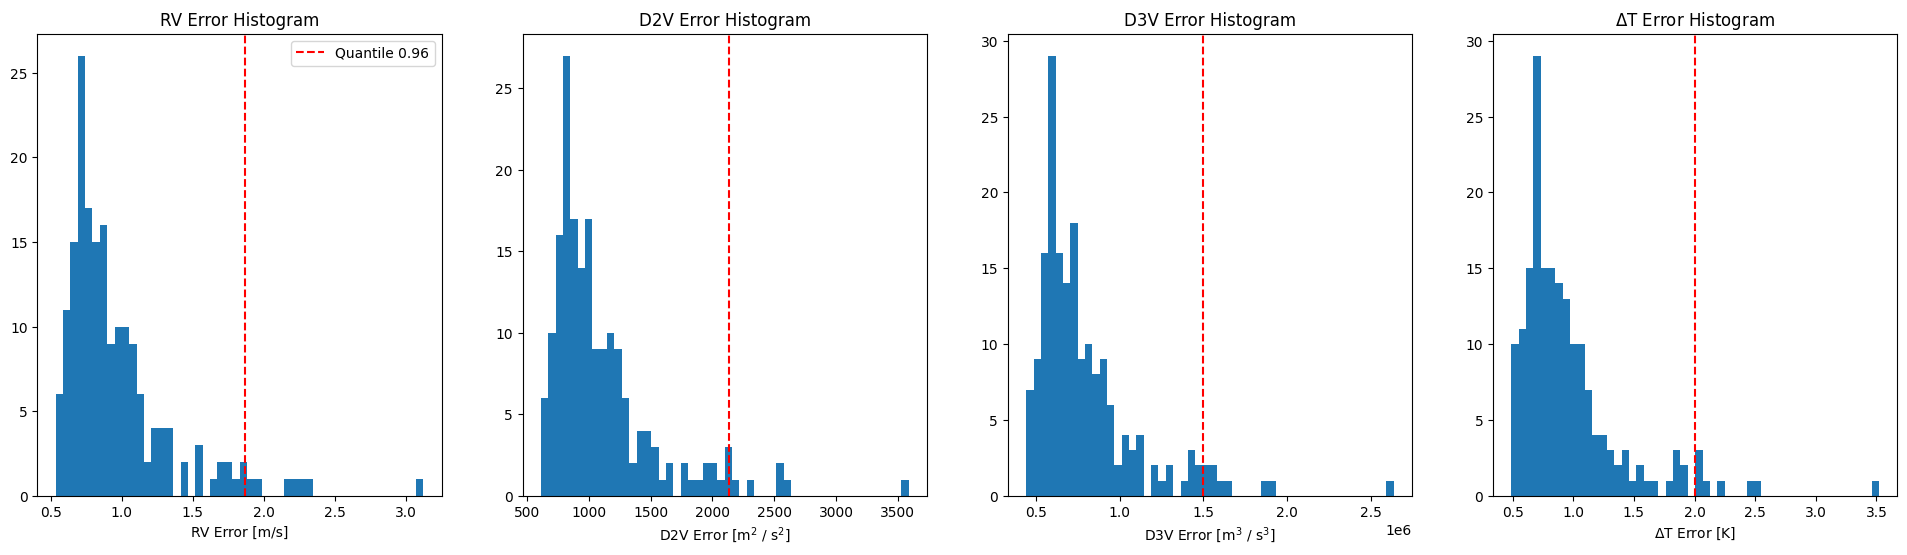

In [9]:
quantile_cut = 0.96
mask_equant = {}
mask_equant_ccf = {}

# LBL data
for instrument in instruments: 
    print(instrument)
    nirps.plot_error_dist(tbl[instrument], qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], qty_list = qty_list[instrument], quantile_cut=quantile_cut)
    plt.show()

    mask_equant[instrument] = nirps.error_quantile_clip(tbl[instrument], qty_list[instrument], quantile_cut, inc_label='s')
    
# CCF data
for instrument in instruments: 
    if ccf[instrument]['DRS-3-0-0']:
        mask_equant_ccf[instrument] = nirps.error_quantile_clip(tbl_ccf[instrument]['DRS-3-0-0'], qty_ccf_list[instrument], quantile_cut, inc_label='sig_')

/home/plamontagne/nirps/nirps_tools.py:180: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx" (-> color='b'). The keyword argument will take precedence.
  axes[i, 0].errorbar(t, y, yerr=yerr, fmt=err_fmt, label=err_label, color=color)


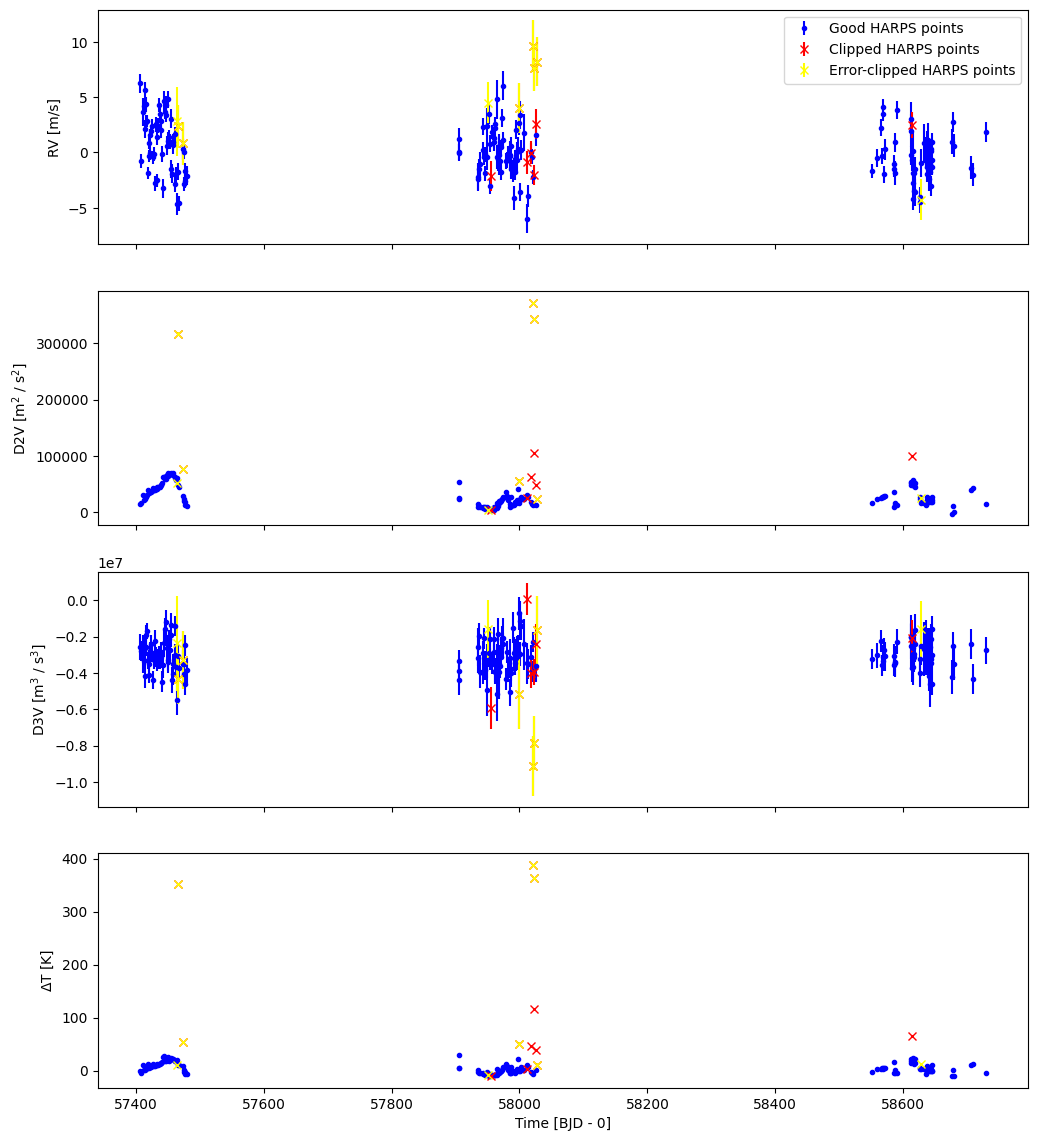

In [10]:
first_time = True
mask = {}
mask_ccf = {}

for instrument in instruments: 
    mask[instrument] = mask_sigma[instrument] | mask_equant[instrument]
    if first_time:
        fig, axes = nirps.plot_timeseries(
            tbl[instrument][~mask[instrument]], qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], qty_list = qty_list[instrument], plot_ls=False,
            err_label=f"Good {instrument} points", color='blue')
        
        nirps.plot_timeseries(
        tbl[instrument][mask_sigma[instrument]],
        qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], qty_list = qty_list[instrument],
        plot_ls=False,
        fig=fig,
        axes=axes,
        err_fmt="rx",
        err_label=f"Clipped {instrument} points",
        color='red')
        
        nirps.plot_timeseries(
        tbl[instrument][mask_equant[instrument]],
        qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], qty_list = qty_list[instrument],
        plot_ls=False,
        fig=fig,
        axes=axes,
        err_fmt="bx",
        err_label=f"Error-clipped {instrument} points",
        color='yellow'
    )
        
    else:  
        nirps.plot_timeseries(
        tbl[instrument][~mask[instrument]],
        qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], qty_list = qty_list[instrument],
        plot_ls=False,
        fig=fig,
        axes=axes,
        err_label=f"Good {instrument} points",
        color='purple')
        
        nirps.plot_timeseries(
        tbl[instrument][mask_sigma[instrument]],
        qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], qty_list = qty_list[instrument],
        plot_ls=False,
        fig=fig,
        axes=axes,
        err_fmt="rx",
        err_label=f"Clipped {instrument} points",
        color='orange')
        
        nirps.plot_timeseries(
        tbl[instrument][mask_equant[instrument]],
        qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], qty_list = qty_list[instrument],
        plot_ls=False,
        fig=fig,
        axes=axes,
        err_fmt="bx",
        err_label=f"Error-clipped {instrument} points",
        color='green'
    )
    
    first_time = False
        
axes[0, 0].legend()
plt.show()

In [11]:
i=0
for instrument in instruments: 

    tbl[instrument][~mask[instrument]].write(files[instrument]+'_preprocessed.rdb', overwrite=True)
    
    # CCF data
    if ccf[instrument]['DRS-3-0-0']:
        mask_ccf[instrument] = mask_sigma_ccf[instrument] | mask_equant_ccf[instrument]
        tbl_ccf[instrument]['DRS-3-0-0'][~mask_equant_ccf[instrument]].write(f'stars/{star}/data/{star}_{instrument}_DRS-3-0-0_preprocessed.rdb', overwrite=True)
    
    i+=1

In [12]:
tbl[instrument][:58]

rjd,vrad,svrad,d2v,sd2v,d3v,sd3v,DTEMP3000,sDTEMP3000,DTEMP3500,sDTEMP3500,DTEMP4000,sDTEMP4000,DTEMP4500,sDTEMP4500,DTEMP5000,sDTEMP5000,DTEMP5500,sDTEMP5500,DTEMP6000,sDTEMP6000,local_file_name,plot_date,dW,sdW,fwhm,sig_fwhm,contrast,sig_contrast,vrad_achromatic,svrad_achromatic,vrad_chromatic_slope,svrad_chromatic_slope,FILENAME,HIERARCH ESO DRS BJD,HIERARCH ESO DET WIN1 DIT1,HIERARCH ESO TEL AIRM START,DATE-OBS,HIERARCH ESO DRS BERV,HIERARCH ESO DPR TYPE,TLPEH2O,TLPEOTR,ITE_RV,RESET_RV,SYSTVELO,HIERARCH ESO DRS CAL TH FILE,HIERARCH ESO OBS TARG NAME,HIERARCH ESO DRS SPE EXT SN47,CCF_EW,LBL_VERSION,LBL_VDATE,LBL_PDATE,LBL_SCI_DIR,vrad_g,svrad_g,vrad_g_0-2044,svrad_g_0-2044,vrad_g_2044-4088,svrad_g_2044-4088,vrad_554nm,svrad_554nm,vrad_563nm,svrad_563nm,vrad_572nm,svrad_572nm,vrad_581nm,svrad_581nm,vrad_591nm,svrad_591nm,vrad_600nm,svrad_600nm,vrad_610nm,svrad_610nm,vrad_620nm,svrad_620nm,vrad_630nm,svrad_630nm,vrad_640nm,svrad_640nm,vrad_651nm,svrad_651nm,vrad_661nm,svrad_661nm,vrad_672nm,svrad_672nm,vrad_683nm,svrad_683nm,vrad_694nm,svrad_694nm,t
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str75,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str75,float64,float64,float64,str23,float64,str14,float64,float64,int64,int64,float64,str41,str16,float64,float64,str8,str10,str23,str82,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
57406.8703990099,6.257924083714897,0.8646086831986592,15448.162633803335,990.6948491501612,-2551958.2412559525,718917.6122430558,-0.3844993690975817,0.8604161768949097,-0.25755263923729665,1.0749668719241285,0.2407634945758632,1.5628803099511932,1.9822463619888009,2.369578184935373,3.7036557141445923,2.8282910365236837,2.4014708231705186,3.1594129966983933,-1.539220375685348,2.0284227359537477,HARPS.2016-01-19T08:45:57.402_e2ds_A_PROXIMA_old_tc_PROXIMA_old_tc_lbl.fits,2416819.87039901,85662.80299561824,5493.578731869557,2232.811881369513,2.504179964300876,0.9924882562965384,0.0005370287362065072,-25889.8694236871,2.2662021679439373,61.91823579157557,22.857010761163586,HARPS.2016-01-19T08:45:57.402_e2ds_A_PROXIMA_old_tc_PROXIMA_old_tc_lbl.fits,2457406.87039901,1199.998291,1.339,2016-01-19T08:45:57.402,18.5491063892083,"STAR,DARK,NONE",0.6820245903601985,1.235123083836616,3,0,44435.98829715904,HARPS.2016-01-18T20:10:48.607_wave_A.fits,Proxima-Centauri,42.0,931.6056044474502,0.63.002,2023-09-22,2024-02-16T14:57:39.986,/home/plamontagne/nirps/run_lbl/data_dir_HARPS/lblrv/PROXIMA_old_tc_PROXIMA_old_tc,-25897.0680015676,7.631877387436203,-25904.802218178465,9.34831556797348,-25881.589126064573,13.21567532643106,-25889.574759806896,5.5621864932296905,-25888.06620852935,3.552454598047866,-25889.366044541574,4.345245826094986,-25886.671430299168,3.6532179740417705,-25892.559247235236,6.099879333063554,-25886.1092171013,5.8536115962602855,-25894.386420034338,5.836366776968821,-25901.78314014995,7.877882976651362,-25881.65620315255,4.500671434749834,-25886.082083713234,2.415594661745806,-25881.44479853465,2.2294498274166346,-25878.445219177214,2.4591944878644427,-25886.210845945054,2.328119863002713,-25879.030733343334,2.4167977644723755,-25885.880768035153,4.314990481357781,57406.8703990099
57407.86189548019,-0.8052083667535044,0.6366519403092954,16879.61519027115,729.6338947387084,-2797920.4679581765,532970.8085506907,-4.524900674575237,0.6771825902848517,-5.834277050451232,0.8459038188477996,-8.264473580442182,1.2311765677843607,-8.539149995466312,1.8741730402887506,-0.20393229491765968,2.241430760099756,5.548910775883014,2.4926352536063403,-1.440451645580958,1.5960024373582162,HARPS.2016-01-20T08:34:13.335

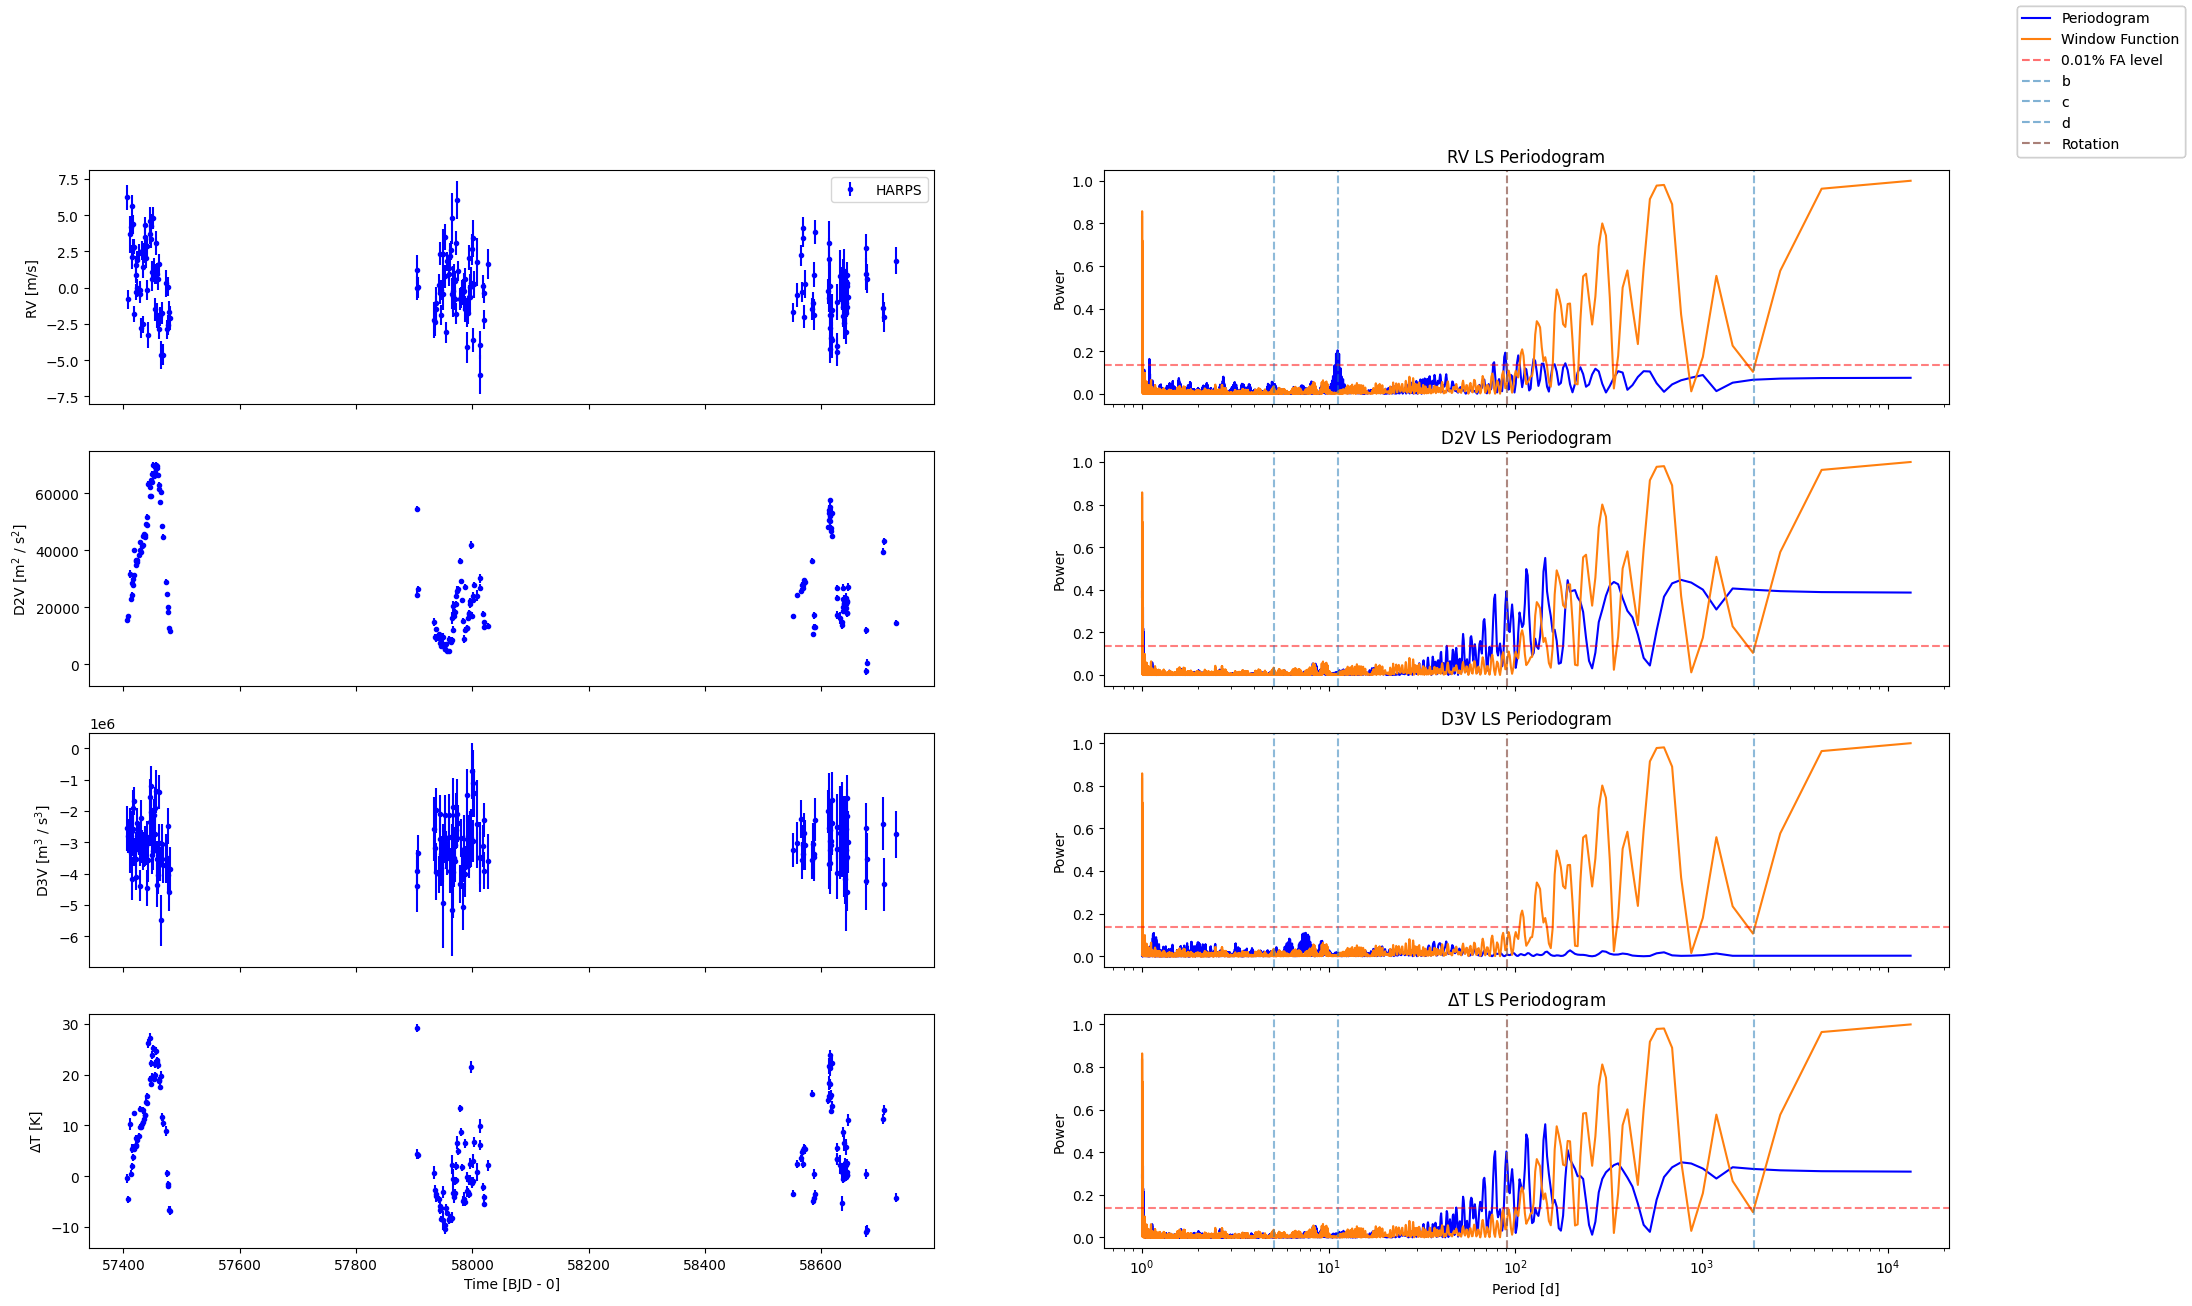

In [13]:
first_time = True
for instrument in instruments: 
    if first_time: 
        fig, axes = nirps.plot_timeseries(tbl[instrument][~mask[instrument]], qty_list[instrument], qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], plot_ls=True, err_label=instrument,
                candidate_planets=system_info['planets'], star_rotation=system_info['period'], color = 'blue')
    else: 
        nirps.plot_timeseries(tbl[instrument][~mask[instrument]], qty_list[instrument], qty_labels=qty_labels[instrument], qty_units=qty_units[instrument], plot_ls=True, err_label=instrument,
                candidate_planets=system_info['planets'], star_rotation=system_info['period'], color = 'red',fig = fig, axes=axes)
        
    
    first_time = False
    
axes[0, 0].legend()
plt.savefig(f"stars/{star}/data/{star}_timeseries_after_correction.png", dpi=300)
plt.show()

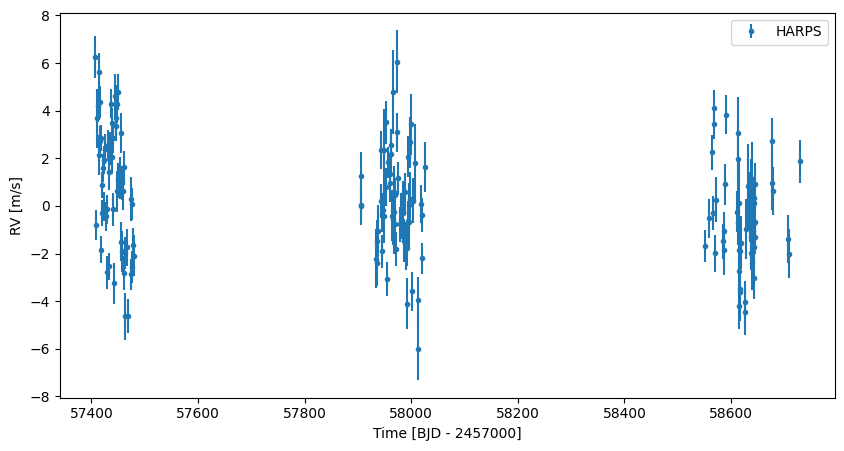

In [37]:
### Show to RV data from all instruments 
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for instrument in instruments: 
    ax.errorbar(tbl[instrument]["t"][~mask[instrument]], 
                tbl[instrument]["vrad"][~mask[instrument]], tbl[instrument]["svrad"][~mask[instrument]], fmt=".", label=instrument)

ax.set_xlabel("Time [BJD - 2457000]")
ax.set_ylabel("RV [m/s]")
ax.legend()
plt.show()


### Plot RV vs BERV to see if there is a linear trend

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


KeyError: 'HIERARCH ESO QC BERV'

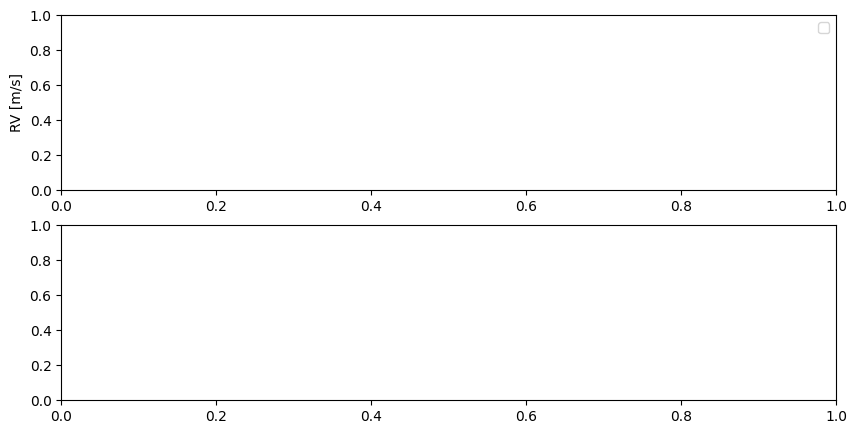

In [15]:
# Plot RV vs BERV for instruments
fig, axes = plt.subplots(2, 1, figsize=(10, 5))


#axes[0].errorbar(tbl['NIRPS']["BERV"][~mask['NIRPS']], tbl['NIRPS']["vrad"][~mask['NIRPS']], fmt='o', color='orange' ,label='NIRPS')
axes[0].set_ylabel("RV [m/s]")
axes[0].legend()

axes[1].errorbar(tbl['HARPS']["HIERARCH ESO QC BERV"][~mask['HARPS']], tbl['HARPS']["vrad"][~mask['HARPS']], fmt='o', color='blue', label='HARPS')
    
axes[1].set_xlabel("BERV [m/s]")
axes[1].set_ylabel("RV [m/s]")
axes[1].legend()

plt.suptitle('Correlation between RV and BERV')
plt.savefig(f"stars/{star}/data/{instrument}_RV_BERV.png", dpi=300)
plt.show()

KeyError: 'DRS-3-0-0'

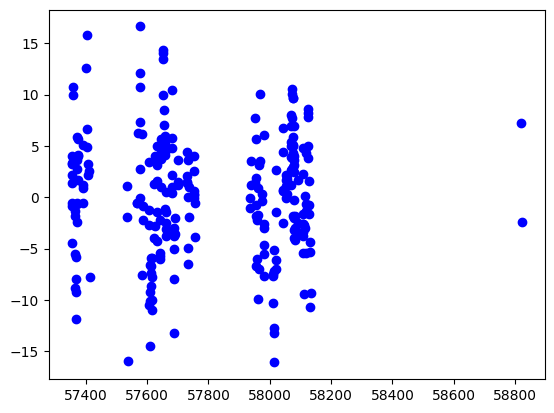

In [ ]:
## Plot LBL data and CCF data on top of each other
plt.plot(tbl['HARPS']["t"][~mask['HARPS']], tbl['HARPS']["vrad"][~mask['HARPS']], 'o', color='blue', label='LBL')
plt.plot(tbl_ccf['HARPS']['DRS-3-0-0']["rjd"][~mask_equant_ccf['HARPS']], tbl_ccf['HARPS']['DRS-3-0-0']["vrad"][~mask_equant_ccf['HARPS']], 'o', color='red', label='CCF')
plt.xlabel('TIME (RJD)')
plt.ylabel('RV (m/s)')
plt.legend()
plt.show()

Ideas: 
- Test GJ682 with the other reference star
- Fit a GP on HARPS data and NIRPS data, the fit a 1-planet model and see if both instruments agree